# Local Invariant Features
## Computer Vision and Image Processing - Lab Session 5 - Exercises
### Prof: Luigi Di Stefano, luigi.distefano@unibo.it
### Tutor: Alex Costanzino, alex.costanzino@unibo.it - Iacopo Curti, iacopo.curti2@unibo.it

### Exercise 1: Object Detection
Given a query image ('ex/bishop.jpg') detect the object in the scene images: 'scene1.jpg', 'scene2.jpg' and 'scene3.jpg'.

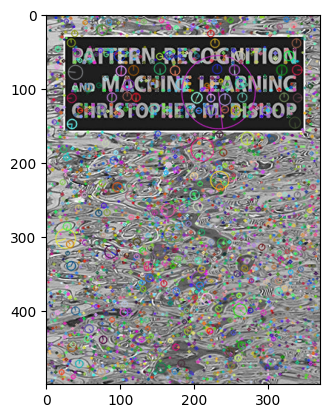

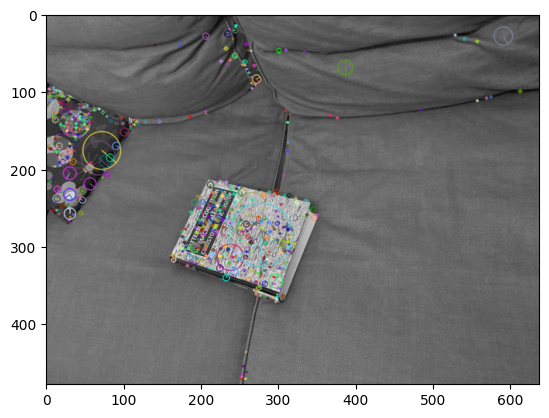

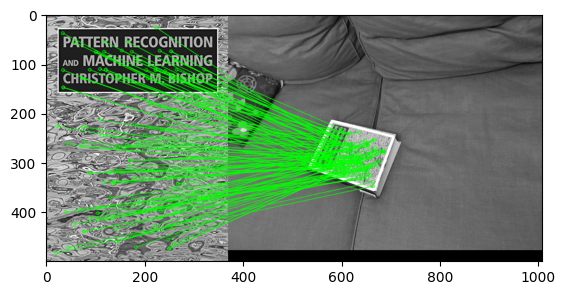

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

###############################################################
#Caricamento immagini e detection dei keypoints
###############################################################
img_train = cv2.imread('ex/scene3.jpg',0) # trainImage
plt.imshow(img_train,cmap='gray',vmin=0,vmax=255)
img_query = cv2.imread('ex/bishop.jpg',0) # queryImage
plt.imshow(img_query,cmap='gray',vmin=0,vmax=255)

sift = cv2.SIFT_create()# Initiate SIFT detector
kp_query = sift.detect(img_query)# find the keypoints and descriptors with SIFT

# print(len(kp_query))# Number of keypoints
# print(kp_query[0].pt)# Location of the keypoint
# print(kp_query[0].size)# Scale
# print(kp_query[0].angle)# Rotation

# Visualize keypoints with drawKeypoints.
img_visualization = cv2.drawKeypoints(img_query,kp_query,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_visualization)
plt.show()
#DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS serve per visualizzare scale and orientation of keypoints

#trovere keypoint nella train image
kp_train = sift.detect(img_train)
img=cv2.drawKeypoints(img_train,kp_train,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
plt.show()


###############################################################
#Keypoints description e matching dei descriptor
###############################################################

# Describing keypoints for query and train images
kp_query, des_query = sift.compute(img_query, kp_query)
kp_train, des_train = sift.compute(img_train, kp_train)

# print("Number of query descriptors: ", len(des_query))
# print("Dimensionality of a SIFT descriptor: ", des_query[0].shape)
# print("Type of the descriptor: ", des_query[0].dtype)


FLANN_INDEX_KDTREE = 1# Defining index for approximate kdtree algorithm
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)# Defining parameters for algorithm 


# Defining search params.
# checks=50 specifies the number of times the trees in the index should be recursively traversed.
# Higher values gives better precision, but also takes more time
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)# Initializing matcher
matches = flann.knnMatch(des_query,des_train,k=2)# Matching and finding the 2 closest elements for each query descriptor.

#filtraggio dei false matches
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)


###############################################################
#step to find the position of the query object in the scene image
###############################################################
# Checking if we found enough matching
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    # building the corrspondences arrays of good matches
    src_pts = np.float32([kp_query[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp_train[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    # Using RANSAC to estimate a robust homography. 
    # It returns the homography M and a mask for the discarded points
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    matchesMask = mask.ravel().tolist()    # Mask of discarded point used in visualization
    h,w = img_query.shape    # Corners of the query image
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    
    dst = cv2.perspectiveTransform(pts,M)    # Projecting the corners into the train image  
    img_train = cv2.polylines(img_train,[np.int32(dst)],True,255,3, cv2.LINE_AA)    # Drawing the bounding box

else:
    print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
    matchesMask = None



# Drawing the matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None, # not draw keypoints only matching lines
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2) # not draw keypoints only lines
img3 = cv2.drawMatches(img_query,kp_query,img_train,kp_train,good,None,**draw_params)
plt.imshow(img3, 'gray')
plt.show()

### Exercise 2: Image Search
Given a query image ('ex/bishop.jpg') and several train images ('ex/scene1.jpg', 'ex/scene2.jpg', 'ex/scene3.jpg', 'ex/scene4.jpg', 'ex/scene5.jpg') implement an image search algorithm to find which images contain the query object.

In [2]:

query_img = cv2.imread('ex/bishop.jpg', 0)  # Query image
train_imgs = [
    'ex/scene1.jpg',
    'ex/scene2.jpg',
    'ex/scene3.jpg',
    'ex/scene4.jpg',
    'ex/scene5.jpg'
]

sift = cv2.SIFT_create()
kp_query, des_query = sift.detectAndCompute(query_img, None)


FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)


results = []

for img_path in train_imgs:
    img_train = cv2.imread(img_path, 0)
    kp_train, des_train = sift.detectAndCompute(img_train, None)

    if des_train is None:
        results.append((img_path, 0))
        continue

    matches = flann.knnMatch(des_query, des_train, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    # Salva numero di good matches
    results.append((img_path, len(good)))


results.sort(key=lambda x: x[1], reverse=True)
print(results)

[('ex/scene2.jpg', 232), ('ex/scene1.jpg', 141), ('ex/scene3.jpg', 125), ('ex/scene4.jpg', 18), ('ex/scene5.jpg', 12)]


### Exercise 3: Mosaicing (aka Panorama Stitching)

Given two images stitch them in a single image. 

Test it on the couples 'ex/bologna_left.jpg' and 'ex/bologna_right.jpg', 'ex/bologna_logo_left.jpg' and  'ex/bologna_logo_right.jpg', 'ex/front_gallery_left.jpg' and 'ex/front_gallery_right.jpg','ex/gallery_left.jpg' and 'ex/gallery_right.jpg','ex/wall_left.jpg' and 'ex/wall_right.jpg'.

_Tips:_ 
* Find correspondences between the images within each couple
* Find an homography
* Warp one image and restore values for the other image 

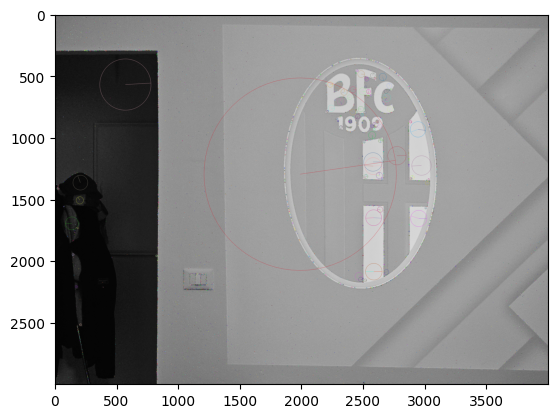

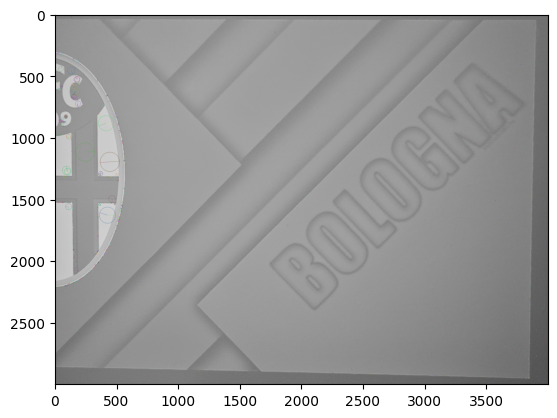

Number of good matches: 48


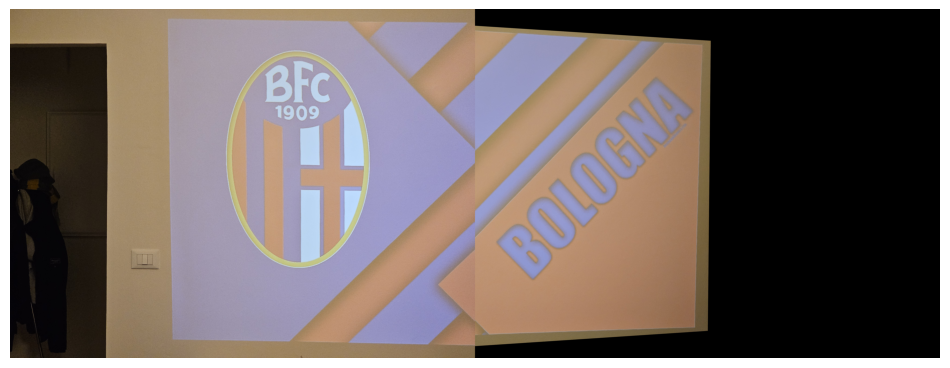

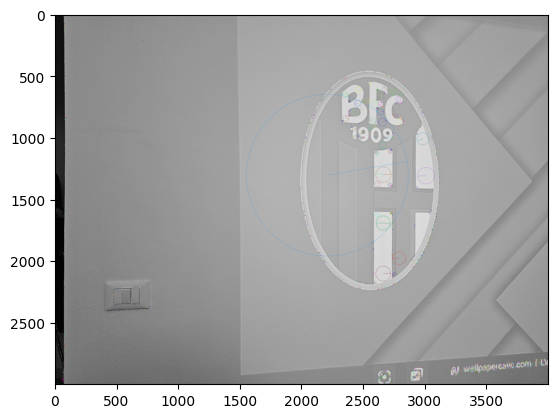

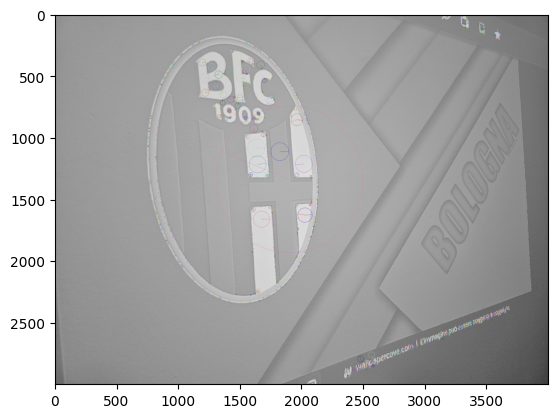

Number of good matches: 226


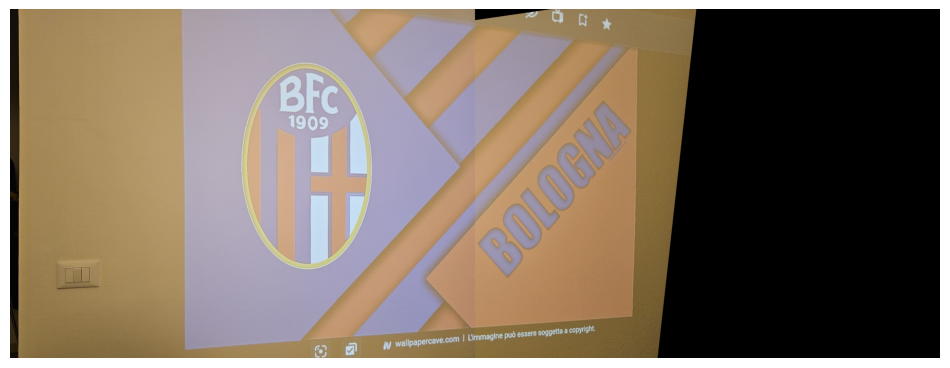

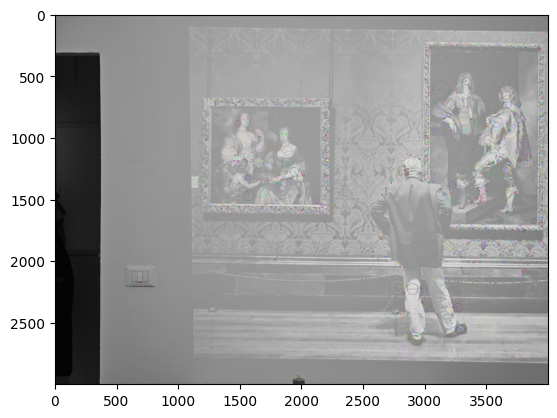

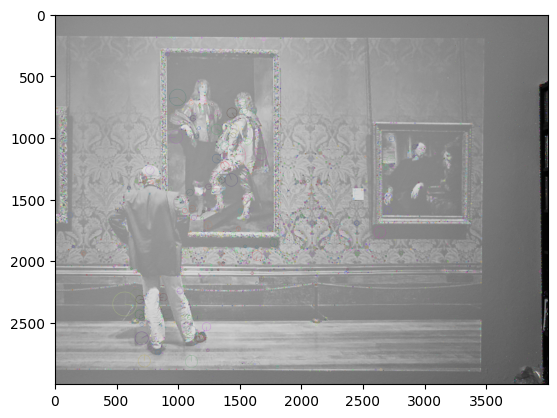

Number of good matches: 1796


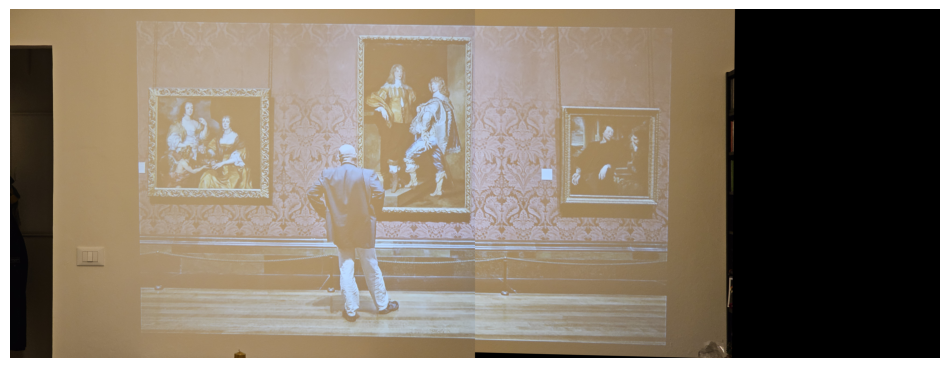

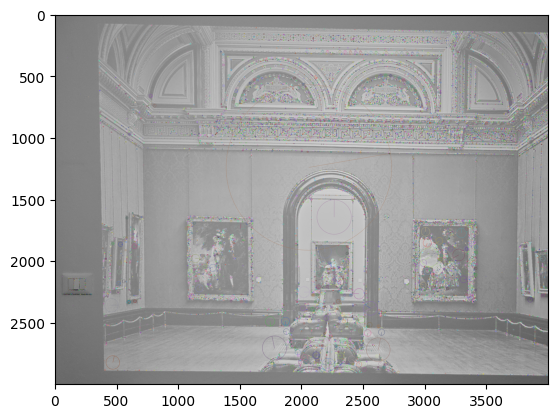

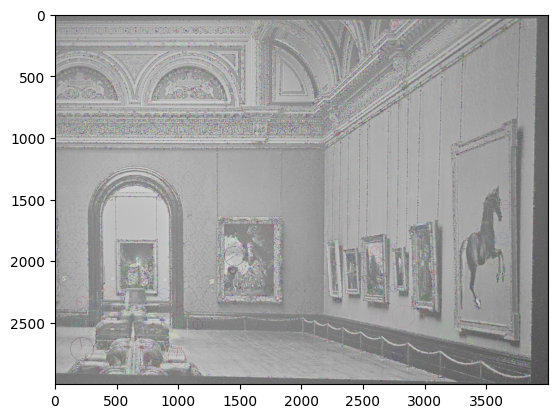

Number of good matches: 3403


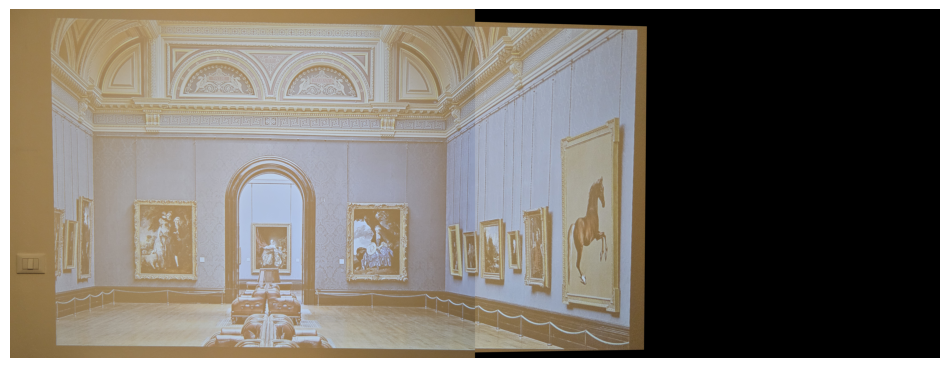

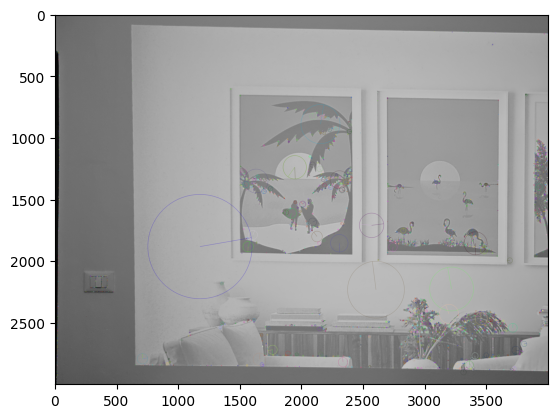

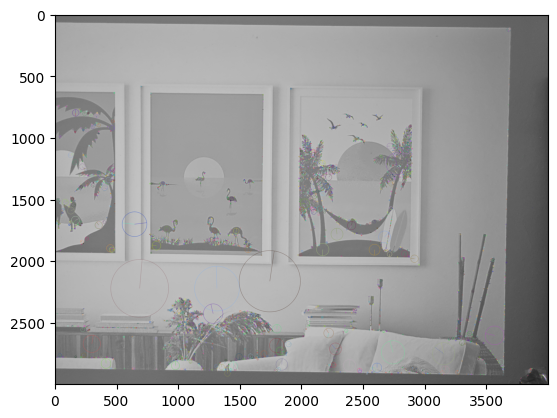

Number of good matches: 1055


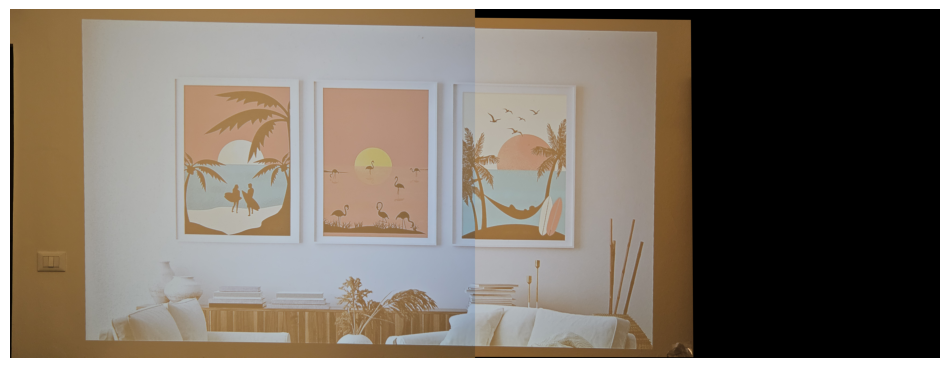

In [3]:
image_pairs = [
    ('ex/bologna_left.jpg', 'ex/bologna_right.jpg'),
    ('ex/bologna_logo_left.jpg', 'ex/bologna_logo_right.jpg'),
    ('ex/front_gallery_left.jpg', 'ex/front_gallery_right.jpg'),
    ('ex/gallery_left.jpg', 'ex/gallery_right.jpg'),
    ('ex/wall_left.jpg', 'ex/wall_right.jpg')
    
]

FLANN_INDEX_KDTREE = 1# Defining index for approximate kdtree algorithm
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)# Defining parameters for algorithm 

search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)# Initializing matcher

for left_path, right_path in image_pairs:

    img_left_color = cv2.imread(left_path) # trainImage
    img_right_color = cv2.imread(right_path) # queryImage

    img_left = cv2.cvtColor(img_left_color, cv2.COLOR_BGR2GRAY)
    img_right = cv2.cvtColor(img_right_color, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()

    kp_left= sift.detect(img_left)
    kp_right= sift.detect(img_right)


    img_visualization_left = cv2.drawKeypoints(img_left,kp_left,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_visualization_left)
    plt.show()

    img_visualization_right = cv2.drawKeypoints(img_right,kp_right,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_visualization_right)
    plt.show()


    kp_left, des_left = sift.compute(img_left, kp_left)
    kp_right, des_right = sift.compute(img_right, kp_right)

    matches = flann.knnMatch(des_right,des_left,k=2)

    #filtraggio dei false matches
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    print(f"Number of good matches: {len(good)}")

    #Omografia
    src_pts = np.float32([kp_right[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp_left[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)


    height, width, channels = img_left_color.shape
    panorama = cv2.warpPerspective(img_right_color, H, (width*2, height))
    panorama[0:height, 0:width] = img_left_color

    # Visualizzazione
    plt.figure(figsize=(12,6))
    plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


### Exercise 4: Augmentated Reality 
Given an image ('ex/stregatto.jpg') implement an augmented reality algorithm to project the image into the surface of the query object ('ex/bishop.jpg).

Moreover, restore the values of the original scene image instead of black pixels obtained with warping. 

Test it on scene images 'ex/scene1.jpg', 'ex/scene2.jpg', 'ex/scene3.jpg'.

_Expected Results_:

<img src="LabSession5Images/ar_ex.png" width="400">

[[165.7519  309.981  ]
 [296.70248 356.6353 ]
 [336.39062 248.23145]
 [211.7528  216.36006]]


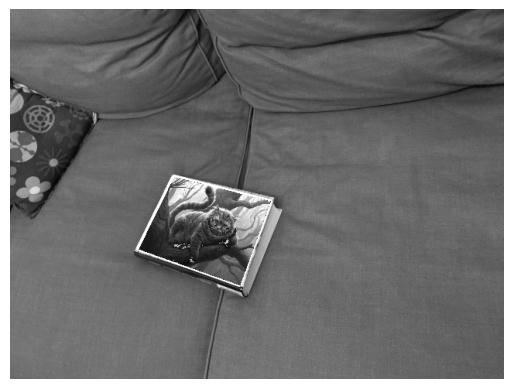

In [4]:
#prima trovo la surface come nell esercizio 1 e poi proietto lo stregatto

###############################################################
#Caricamento immagini e detection dei keypoints
###############################################################
img_train = cv2.imread('ex/scene3.jpg',0)
img_query_color = cv2.imread('ex/bishop.jpg') 
img_query = cv2.cvtColor(img_query_color, cv2.COLOR_BGR2GRAY)
img_color = cv2.imread('ex/stregatto.jpg') 
img_to_project = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()# Initiate SIFT detector
kp_query = sift.detect(img_query)# find the keypoints and descriptors with SIFT
kp_train = sift.detect(img_train)

###############################################################
#Keypoints description e matching dei descriptor
###############################################################

# Describing keypoints for query and train images
kp_query, des_query = sift.compute(img_query, kp_query)
kp_train, des_train = sift.compute(img_train, kp_train)

FLANN_INDEX_KDTREE = 1# Defining index for approximate kdtree algorithm
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)# Defining parameters for algorithm 

search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)# Initializing matcher
matches = flann.knnMatch(des_query,des_train,k=2)# Matching and finding the 2 closest elements for each query descriptor.

#filtraggio dei false matches
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)


###############################################################
#step to find the position of the query object in the scene image
###############################################################
# Checking if we found enough matching
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    # building the corrspondences arrays of good matches
    src_pts = np.float32([kp_query[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp_train[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    # Using RANSAC to estimate a robust homography. 
    # It returns the homography M and a mask for the discarded points
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    matchesMask = mask.ravel().tolist()    # Mask of discarded point used in visualization
    h,w = img_query.shape    # Corners of the query image
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    
    dst = cv2.perspectiveTransform(pts,M)    # Projecting the corners into the train image  
    img_train = cv2.polylines(img_train,[np.int32(dst)],True,255,3, cv2.LINE_AA)    # Drawing the bounding box

else:
    print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
    matchesMask = None



coord_dest = dst.reshape(4, 2).astype("float32")
print(coord_dest)

# Coordinate of the border of the image we want to project
h_2, w_2=  img_to_project.shape[0], img_to_project.shape[1]
coord2proj = np.array([
    [w_2 - 1, h_2 - 1],
    [0, h_2 - 1],
    [0, 0],
    [w_2 - 1, 0]
], dtype = "float32")


M = cv2.getPerspectiveTransform(coord2proj,coord_dest)

# Warpa la src in bianco e nero
warped = cv2.warpPerspective(img_to_project, M, (img_train.shape[1], img_train.shape[0]))#lo stregatto appare solo nel quadrilatero del bounding box

mask = warped < 10   # pixel dove lo stregatto è nero
warped[mask] = img_train[mask] #voglio sostituire i pixel neri

plt.imshow(warped, cmap='gray')
plt.axis("off")
plt.show()

